# Genetic Algorithm - CW2

This code was created from scratch

### Install and import libaries 

Crossover and Mutation Operators of Genetic Algorithms
Siew Mooi Lim, Abu Bakar Md. Sultan, Md. Nasir Sulaiman, Aida Mustapha, and K. Y. Leong - mutation and crossover ref

In [ ]:
# Install optproblems libary 

!pip install optproblems

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import statistics as stat
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import optproblems 
from optproblems import cec2005
from random import random 
from random import seed
from random import randint

## Genetic Algorithm Class

This class contains the hyperparameters and functions required to perform the steps in the GA and some helper functions 

### Main functions 

The initial solutions are made by creating a list of random values and assigning that list as a phenome to an object of type individual. Each solution is the added to the list of solutions for the generation. 

The fitness of each soltuion is calculated by summing each element of the phenome and it's objective value and comparing it with that of the optimal solution. The absolute of the inverse of this value is then assigned as it's fitness value. This is to ensure the GA optimises both the objective value and the phenome to avoid getting trapped in local minima. 

Tournament selection is perfomed to obtain the parent solution for the next generation. Each parent solution is found by sampling a random selection of size k of the current generation and finding the solution with the best fitness value. 

One point cross over is used to create the new generation of solutions. The cross over rate is used to determine what percentage of new solutions will be generated by this method, with a high cross over rate meaning nore solutions generated using one point cross over. The cross over point of the solutions is generated randomly for each pair of parents. The random order of the list of parents allows the algorithm to perfrom cross over on parents which follow each other in the list. Once the cross over point is found the parents swap their parts around after this point to create the new child solutions. 

The new generation of child solutions are mutated at a random element within the phenome with a random value within the bounds of the problem. The mutation rate determines what percentage of the new child solutions are mutated. 

### Helper Functions

There is a helper function which finds the generation's best solution, it's fitness and the average fitness of all solutions in the generation. There is also a function which displays the solutions on a graph of the function when the dimetion of the solution is 2. 

In [ ]:
# Genetic Algorithm Class 

class GA: 
  def __init__(self, popSize, solnSize, bound, k, mutProb, crsProb, func):     # Constructor
    
    self.popSize = popSize        # the population size of the generation 
    self.solnSize = solnSize      # the solution size for each solution in the generation
    self.bound = bound            # the upper/lower bound of the function
    self.k = k                    # the number of solutions used in a round of tournament selections
    self.mutProb = mutProb        # mutatation probability of a solution being mutated 
    self.crsProb = crsProb        # crossover probability of a child solution being generated by cross point selection 
    self.func = func              # the optproblems function 
    self.initGen = []             # the initial generation of solutions stored in a list
    self.currentGen = []          # the current generation of solutions stored in a list
    self.fitList = []             # the fitness values of the current generation of solutions in a list
    self.parentSel = []           # the list of parent solutions generated from tournament selection
    self.bestSoln = []            # the best solution's phenome stored in a list

    ans = self.func.get_optimal_solutions()     # get list of optimal solutions 
    optSoln = ans[0]                            # store first (and normally only?) optimal solution 
    self.func.evaluate(optSoln)                 # evaluate the optimal solution 
    self.optSoln = optSoln                      # store the optimal solution 


  def createGenOptLib(self):                  # create initial population of random solutions using the hyperparameters    
    self.initGen = []                                                 # reset the initial generation to be an empty list
    
    for i in range(self.popSize):                                     # for each member of the population
      soln = []                                                       # initialise list for a solution 
      for j in range(self.solnSize):                                  # for each element of the solution 
	      soln.append(round((random()*2*self.bound - self.bound), 4))   # generate a random number within the bounds of the problem with 4dp (like optproblems) 
      idiv = optproblems.Individual(soln)                             # create an instance of individual from optproblems with the solution generated above
      self.initGen.append(idiv)                                       # append the individual containing the solution as a phenome to the list of solutions

    self.currentGen = self.initGen                                    # store the initial solutions 
  

  def fitnessOptLib(self):                                  # assess the fitness of the functions 
    # fitness = 1/|(x + y + z + ... - t)| where t is the optimal x, y, z, ... summed 
    self.func.batch_evaluate(self.currentGen)               # evaluate z for the population 
    self.fitList = []                                       # ensure the list is empty 

    t = self.optSoln.objective_values                       # add value of z to the sum of the optimal solution's parts    
    for k in range(self.solnSize):                          # for each element in the optimal solution 
      t += self.optSoln.phenome[k]                          # add the element to the sum of the optimal solution's parts

    for i in range(self.popSize):                           # for each solution in the current generation 
      sum = self.currentGen[i].objective_values             # add value of z to the sum of the current solution's parts
      for j in range(self.solnSize):                        # for each element in the solution 
        sum += self.currentGen[i].phenome[j]                # add the element to the sum of the current solution's parts
      
      self.fitList.append(1/abs(sum - t))                   # calculate and store the solution's fitness to the list of fitness values 


  def tourSelOptLib(self):         # get a list of parent solutions using tournament selection 
    self.parentSel = []
    maxIndex = len(self.fitList)-1                            # calculate the maximum index value

    for j in range(self.popSize):                             # ensure the generation size stays the same by selecting the same number of parent soluntions  
      best = -1                                               # set the best fitness value to be negative 
      bestIndex = -1                                          # set the index which is used to get the fittest solution from the selection list
      newRandIndex = []                                       # list to remember which indexes have been used in the selection  
    
      for i in range(self.k):                                 # for each soln in selection k 
        index = randint(0, maxIndex)                          # get random soln index to pick a solution
      
        if newRandIndex.count(index):                         # make sure there are no duplicate solutions in the selection
          i -= 1                                              # if there, go back and pick a new index 
        else:
          newRandIndex.append(index)                          # add index of this solution to list of indexes for this selection 
          if best <= self.fitList[index]:                     # checks if it is the fittest solution in the selection
            best = self.fitList[index]                        # makes it the new best fitness for this selection 
            bestIndex = index                                 # remembers the new best index for this selection
    
      self.parentSel.append(self.currentGen[bestIndex])       # add the best solution of the selection to list of parents 


  def onePtrCrsOptLib(self):                # specify how much of the parent you want left behind

    ng = []                                                 # list to hold children solutions

    for i in range(0, self.popSize-1, 2):                   # for each pair of parents

      crsPt = randint(0, self.solnSize-1)                    # generate a random crossover point 

      parent1 = self.parentSel[i].phenome                   # get first parent solution from solution list
      parent2 = self.parentSel[i+1].phenome                 # get seccond parent solution from solution list

      newStart1 = parent1[0:crsPt]                          # get start of first parent solution
      newStart2 = parent2[0:crsPt]                          # get start of second parent solution

      newEnd1 = parent1[crsPt::]                            # get end of first parent solution
      newEnd2 = parent2[crsPt::]                            # get end of second parent solution

      child1 = optproblems.Individual(newStart1 + newEnd2)  # create child with start of first parent and end of second parent
      child2 = optproblems.Individual(newStart2 + newEnd1)  # create child with start of second parent and end of first parent

      ng.append(child1)                                     # add new child to list of new child population
      ng.append(child2)                                     # add new child to list of new child population
      
    self.currentGen = ng                                    # update the current generation 

  def onePtrCrsOptLibProb(self):                # specify how much of the parent you want left behind

    ng = []                                                 # list to hold children solutions
    numCrsPt = int(self.mutProb * self.popSize)
    
    for i in range(0, numCrsPt-1, 2):                   # for each pair of parents

      crsPt = randint(0, self.solnSize-1)                    # generate a random crossover point 

      parent1 = self.parentSel.pop()                   # get first parent solution from solution list
      parent2 = self.parentSel.pop()              # get seccond parent solution from solution list

      newStart1 = parent1.phenome[0:crsPt]                          # get start of first parent solution
      newStart2 = parent2.phenome[0:crsPt]                          # get start of second parent solution

      newEnd1 = parent1.phenome[crsPt::]                            # get end of first parent solution
      newEnd2 = parent2.phenome[crsPt::]                            # get end of second parent solution

      child1 = optproblems.Individual(newStart1 + newEnd2)  # create child with start of first parent and end of second parent
      child2 = optproblems.Individual(newStart2 + newEnd1)  # create child with start of second parent and end of first parent

      ng.append(child1)                                     # add new child to list of new child population
      ng.append(child2)                                     # add new child to list of new child population
       
    self.currentGen = ng + self.parentSel                                    # update the current generation 


  def mutateOptLib(self):                      # mutate the new generation 

    for i in range(self.popSize):                                                                              # for each solution in the population
      self.currentGen[i].phenome[randint(0, self.solnSize-1)] = round((random()*2*self.bound - self.bound), 4) # must it ensure the child always be mutated?

  def mutateOptLibProb(self):                      # mutate the new generation 
    numMutate = int(self.popSize * self.crsProb)

    mutateSoln = []
    
    for i in range(numMutate):
      #print(len(self.currentGen))                                                                              # for each solution in the population
      mutateSoln.append(self.currentGen.pop(randint(0, len(self.currentGen)-1)))
      mutateSoln[i].phenome[randint(0, self.solnSize-1)] = round((random()*2*self.bound - self.bound), 4) # must it ensure the child always be mutated?

    self.currentGen = self.currentGen + mutateSoln


  def getBestSoln(self):                          # get the best soltion of the generation 
    
    self.fitnessOptLib()                          # get fitness of each solution in the generation 
    maxFit = max(self.fitList)                    # get the fittest value
    avgFit = sum(self.fitList)/len(self.fitList)
    maxFitIndex = self.fitList.index(maxFit)      # get the index of the fittest solution 
    
    self.bestSoln = self.currentGen[maxFitIndex]  # store the best solution ## Remove .phenome to calc better standard dev later??
    
    # print statements 
    print("The fittest solution was: ", self.bestSoln.phenome)   
    print("The optimal solution was: ", self.optSoln.phenome)

    print("Best fit was ", maxFit)
    print("Average fit was ", avgFit)
  
  def getBestSoln2(self):                          # get the best soltion of the generation 
    
    self.fitnessOptLib()                          # get fitness of each solution in the generation 
    maxFit = max(self.fitList)                    # get the fittest value
    avgFit = sum(self.fitList)/len(self.fitList)  # calculate the average fitness of the generation 
    maxFitIndex = self.fitList.index(maxFit)      # get the index of the fittest solution 
    
    self.bestSoln = self.currentGen[maxFitIndex]  # store the best solution ## Remove .phenome to calc better standard dev later??
    
    # print statements 
    #print("The fittest solution was: ", self.bestSoln.phenome)   
    #print("The optimal solution was: ", self.optSoln.phenome)

    #print("Best fit was ", maxFit)
    #print("Average fit was ", avgFit)

    return maxFit, avgFit

  def display(self):              # display the solution on a graph (iff solution size is 2)
    ## plot from blog 

    boundT = 2*self.bound

    # initialise two 2D arrays to represent the x and y coordinates for the graph of the function from optproblems 
    x, y = np.array(np.meshgrid(np.linspace(-self.bound,self.bound,boundT), np.linspace(-self.bound,self.bound,boundT)))

    # creates a 2D array to store the function result to be graphed 
    z = np.zeros([boundT, boundT])


    for i in range(boundT):                                             # for every row 
      for j in range(boundT):                                           # for every element
        plotSoln = optproblems.Individual(np.array([x[i][j], y[i][j]])) # create a solution using the coordinates
        self.func.evaluate(plotSoln)                                    # evaluate the solution
        z[i][j] = plotSoln.objective_values                             # add the evaluation of the solution to z

    # set up arrays for scattering the first and final generations on the graph
    xFirst = np.zeros(self.popSize)                                          
    yFirst = np.zeros(self.popSize)
    xFinal = np.zeros(self.popSize) 
    yFinal = np.zeros(self.popSize)

    # get the coordinates for the first generation 
    for i in range(self.popSize):
      xFirst[i] = self.initGen[i].phenome[0]
      yFirst[i] = self.initGen[i].phenome[1]

    # get the coordinates for the last generation 
    for i in range(self.popSize):
      xFinal[i] = self.currentGen[i].phenome[0]
      yFinal[i] = self.currentGen[i].phenome[1]

    # get the coordinates of the optimal(smallest) point on the function
    x_min = x.reshape(-1)[z.argmin()]     # flatten the array of x coordinates and find the value with the same index as to the smallest value of z 
    y_min = y.reshape(-1)[z.argmin()]     # flatten the array of y coordinates and find the value with the same index as to the smallest value of z 

    # adjust the size of the plot in inches 
    #plt.figure(figsize=(8,6))

    # plot the image of the function from optproblems within the bounds supplied 
    plt.imshow(z, extent=[-self.bound, self.bound, -self.bound, self.bound], origin='lower', cmap='PuBuGn', alpha=1)

    # display the colourbar to illustrate the depth (z)
    plt.colorbar()

    # plot the optimal solution with a black x
    plt.plot([x_min], [y_min], marker='x', markersize=5, color="green", label="Optimal")

    # plot the best solution with a black triange
    plt.plot(self.bestSoln.phenome[0], self.bestSoln.phenome[1], marker='^', markersize=5, color="green", label="Best")

    # plot the contours of the function 
    contours = plt.contour(x, y, z, colors='black', alpha=0.4)
    plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    # plot the coordinates which represent the solutions from the first generation 
    plt.scatter(xFirst, yFirst, 5, c="orange", label="first generation")

    # plot the coordinates which represent the solutions from the last generation   
    plt.scatter(xFinal, yFinal, 5, c="red", label="last generation")

    # show the legend
    plt.legend()

    # show the graph
    plt.show()

# Class used to run the genetic algorithm 

class Run():

  def run(self, maxGen, GA): 

    GA.createGenOptLib()         # create initial solution 
    
    i = 0

    while i<maxGen:
      
      GA.fitnessOptLib()         # fitness 
      GA.tourSelOptLib()         # tournament selection 
      GA.onePtrCrsOptLib()       # crossover

      i += 1                     # increment counter 

      if GA.currentGen.count(GA.optSoln):                            # if optimum solution has been found
        print("soln found")
        GA.getBestSoln()
        break
      elif i==maxGen:                                  # if max number of generations has been reached
        print("MAXIMUM NUMBER OF GENERATIONS REACHED")
        GA.getBestSoln()
        break

      GA.mutateOptLib()          # mutate
    
    if GA.solnSize == 2:
      GA.display()

    print("DONE")

  def runTen(self, maxGen, GA): 
    
    bestSolnList = []

    i = 0

    while i<10:
      self.run(maxGen, GA)
      bestSolnList.append(GA.bestSoln)
      i += 1
    

    # accuracy of algorithm - average of objective value compared to answer 


    avgSum = 0
    blob = []
    for i in range(10):
      blob.append(bestSolnList[i].objective_values)
      avgSum += bestSolnList[i].objective_values

    averageObjVal = sum(blob)/len(blob)
    print("Actual =", GA.optSoln.objective_values)
    print("Average =", averageObjVal)
    accuracy = abs((GA.optSoln.objective_values - averageObjVal)/GA.optSoln.objective_values) * 100

    print("percenatge error of value = ", accuracy)


    # standard dev to show robustness of GA 

    # using objective values 
    
    stdDevObjVal = stat.pstdev(blob)
    
    print("The Standard Deviation of best value of the past 10 runs is ", stdDevObjVal)

    
    # using solution phenome

    bestTrspd = []
    stdSum = []
    stdAvg = np.zeros(GA.solnSize)
    stdAcc = []

    resStdDev = []

    for i in range(GA.solnSize):                # for each element
      stdSum = []
      for j in range(10):                       # for each GA
        stdSum.append(bestSolnList[j].phenome[i]) # store the elements at position i of all solutions 
      stdAvg[i] = sum(stdSum)/len(stdSum)       # calculate the avergae of the element at pos i
      stdAcc.append(abs((GA.optSoln.phenome[i] - stdAvg[i])/GA.optSoln.phenome[i]) * 100) #calculate percentage error of element i
      resStdDev.append(stat.pstdev(stdSum))
    
    perErr = sum(stdAcc)/len(stdAcc)             # calculate avg percentage error for all elements in solution 
    print("Avg percentage error for elements of solution is ", perErr)
    
    avgStdDev = sum(resStdDev)/len(resStdDev)
    print("Avg standard deviation for elements of solution is ", avgStdDev)
    
    






  def runOne(self, maxGen, GA): 

    GA.createGenOptLib()         # create initial solution 
    
    i = 0
    maxFitList = []
    avgFitList = []

    while i<maxGen:
      
      GA.fitnessOptLib()         # fitness 
      GA.tourSelOptLib()         # tournament selection 
      GA.onePtrCrsOptLib()       # crossover
      maxFit, avgFit = GA.getBestSoln2()
      maxFitList.append(maxFit)
      avgFitList.append(avgFit)
      i += 1                     # increment counter 

      if GA.currentGen.count(GA.optSoln):                            # if optimum solution has been found
        print("soln found")
        GA.getBestSoln()
        break
      elif i==maxGen:                                  # if max number of generations has been reached
        print("MAXIMUM NUMBER OF GENERATIONS REACHED")
        GA.getBestSoln()
        break

      GA.mutateOptLib()          # mutate
    
    if GA.solnSize == 2:
      GA.display()

    print("best fit was ", max(maxFitList))
    x = np.linspace(0,len(maxFitList)-1, len(maxFitList))
    plt.plot(x, maxFitList, color="green")
    plt.plot(x, avgFitList, color="red")

    print("DONE")



    #print(bestTrspd[0])
    #print(bestSolnList[0].phenome)
    
  #  for i in range(10):
    #  bestTrspd.append(np.array(bestSolnList[i].phenome[j]).T.tolist())    
    #for i in range(GA.solnSize):
      #resStdDev.append(stat.pstdev(bestTrspd[i]))

    #print("The Standard Deviation of best solutions of the past 10 runs is ", resStdDev)

    #sumS = 0
    #for r in range(len(resStdDev)):
    #  sumS += resStdDev[r]
    #mean = sumS/len(resStdDev)
    #print("The average Standard Deviation of the elements is ", mean)



MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-99.6979, 99.4746]
The optimal solution was:  [-100.0, 100.0]
Best fit was  0.070039292042835
Average fit was  0.02429407943310935


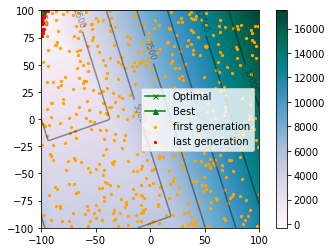

DONE


In [32]:
funcMain = optproblems.cec2005.F5(2)
newGA = GA(popSize=500, solnSize=2, bound=100, k=100, mutProb=1, crsProb=1, func=funcMain)

Run().run(100, newGA)

In [41]:
dim = 10



funcMain = optproblems.cec2005.F1(dim)

newGA = GA(popSize=500, solnSize=dim, bound=100, k=100, mutProb=1, crsProb=1, func=funcMain)
#newGA = GA(popSize=100, solnSize=dim, bound=100, k=100, func=funcMain)



r = Run()
#r.run(10, newGA)
r.runTen(500, newGA)
#r.runOne(50, newGA)


#F14

MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-40.0549, 59.1502, -47.193, -75.7867, -17.4437, -81.1623, -10.6944, 24.7095, 88.8553, 9.7261]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Best fit was  2.568806773841205
Average fit was  0.3066771897276338
DONE
MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-38.8171, 57.9516, -47.2127, -74.8751, -17.0988, -81.1446, -10.6333, 24.6088, 89.457, 10.0682]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Best fit was  0.748567939004265
Average fit was  0.17931758433301917
DONE
MAXIMUM NUMBER OF GENERATIONS REACHED
The fittest solution was:  [-40.5326, 58.0985, -47.4328, -75.4812, -17.1962, -80.9218, -11.7086, 24.3136, 88.986, 9.5433]
The optimal solution was:  [-39.3119, 58.8999, -46.3224, -74.6515, -16.7997, -80.5441, -10.5935, 24.9694, 89.8384, 9.1119]
Bes

In [ ]:
aa = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
bb = np.array(aa).T.tolist()

print(aa)
print(bb)

[[1, 2, 3], [1, 2, 3], [1, 2, 3]]
[[1, 1, 1], [2, 2, 2], [3, 3, 3]]


In [ ]:
numF = input ("Enter function number :") 
print(numF)
numSS = input ("Enter dimetion (SolnSize) number :") 
print(numSS)
#confirm = input("You want function ", num, ". Please confirm by typing Y, otherwise you will be asked again")



def getBounds(num):
  bound100 = [1, 2, 3, 4, 5, 6, 14]
  bound5 = [9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  
  if bound100.count(num) == 1:
    uBound = 100
    lBound = -100
  elif bound5.count(num) == 1:
    uBound = 5
    lBound = -5
  elif num == 8:
    uBound = 32
    lBound = -32
  elif num == 11:
    uBound = 0.5
    lBound = -0.5
  elif num == 12: 
    uBound = np.pi
    lBound = -np.pi
  elif num == 13:
    uBound = 1
    lBound = -3
  elif num == 7:
    uBound = 0
    lbound = -600
  elif num == 25:
    uBound = 0
    lbound = -5
  return uBound, lBound

def getFunc(numF, numSS):
  #numF = "F"+str(numF)
  #print(numF)
  #func = optproblems.cec2005.numF(10)
  
#
getFunc(1, 3)


IndentationError: ignored

In [ ]:
func = optproblems.cec2005.F25(10)
ans = func.get_optimal_solutions()     # get list of optimal solutions 
optSoln = ans[0]                            # store first (and normally only?) optimal solution 
func.evaluate(optSoln)                 # evaluate the optimal solution 
print(optSoln.objective_values) 
print(optSoln.phenome) 

260.0
[-2.933, -3.034, -4.3583, -4.2851, -3.505, -1.4618, -3.7277, -2.1445, -3.1317, -2.5637]


TODO: comand line prompts? 

# STOP HERE

Rest is old code and tests - ignore

In [ ]:
# FUNCTIONS - IGNORE


def createGenOptLib(popSize, solnSize, bound):                  # create initial population of random solutions using the hyperparameters 

  gen = []                                                # initialise list of solutions 
  for i in range(popSize):                                # for each member of the population
    soln = []                                             # initialise list for a solution 
    for j in range(solnSize):                             # for each element of the solution 
	    soln.append(round((random()*2*bound - bound), 4))   # generate a random number within the bounds of the problem and 
    idiv = optproblems.Individual(soln)                   # create an instance of individual from optproblems 
    gen.append(idiv)                                      # append the individual containing the solution as a phenome to the list of solutions
  return gen                                              # return the list of solutions


def fitnessOptLib(gen, bound, func):                                      # assess the fitness of the functions 
  
  # idea - fitness = 1/|(x + y + z - t)| where t is the optimal x, y and z summed 
  # https://towardsdatascience.com/how-to-define-a-fitness-function-in-a-genetic-algorithm-be572b9ea3b4
  
  func.batch_evaluate(gen)               # evaluate z for the population 
  ans = func.get_optimal_solutions()    # get list of optimal solutions 
  optSoln = ans[0]                      # store first (and normally only?) optimal solution 
  func.evaluate(optSoln)                # evaluate the optimal solution 
  
  popSize = len(gen)                    # get size of population 
  solnSize = len(gen[0].phenome)        # get size of solution 
  fit = []                              # list to store fitness values for each solution 

  t = optSoln.objective_values          # add value of z to the sum
  for k in range(solnSize):             # for each element in the solution 
    t += optSoln.phenome[k]             # add xj to the sum 

  for i in range(popSize):              # for each solution 
    sum = gen[i].objective_values       # add value of z to the sum
    for j in range(solnSize):           # for each element in the solution 
      sum += gen[i].phenome[j]          # add xj to the sum 
    fit.append(1/abs(sum - t))          # add the solution's fitness to the list of fitness values 

  return fit                            # return list of fitness values 


def tourSelOptLib(gen, k, fit):         # get a list of parent solutions using tournament selection 
  
  popSize = len(gen)                    # size of generation 
  pf = []                               # list to store fitness of parents (for testing)
  pg = []                               # list to store the selection of parents from tournement selection
  
  for j in range(popSize):              # ensure the generation size stays the same by selecting the same number of parent soluntions  
    best = -1                           # set the best fitness value to be negative 
    bestIndex = -1                      # set the index which is used to get the fittest solution from the selection list
    newRandIndex = []                   # list to remember which indexes have been used in the selection  
    
    for i in range(k):                  # for each soln in selection k 
      index = randint(0, len(fit)-1)    # get random soln index to pick a solution
      
      if newRandIndex.count(index):     # make sure there are no duplicate solutions in the selection
        i -= 1                          # if there, go back and pick a new index 
      else:
        newRandIndex.append(index)      # add index of this solution to list of indexes for this selection 
        if best <= fit[index]:          # checks if it is the fittest solution in the selection
          best = fit[index]             # makes it the new best fitness for this selection 
          bestIndex = index             # remembers the new best index for this selection
    
    pf.append(fit[bestIndex])           # add the best fitness of the selection to list of parents
    pg.append(gen[bestIndex])           # add the best solution of the selection to list of parents 

  return pg, pf                         # return the list of parents and the list of their fitnesses


def onePtrCrsOptLib(pg):                # specify how much of the parent you want left behind
  
  popSize = len(pg)
  ng = []                               # list to hold children

  for i in range(0, popSize-1, 2):      # for each pair of parents

    crsPt = randint(0, popSize-1)       # generate a random crossover point 

    parent1 = pg[i].phenome             # get first parent solution from solution list
    parent2 = pg[i].phenome             # get seccond parent solution from solution list

    newStart1 = parent1[0:crsPt]        # get start of first parent solution
    newStart2 = parent2[0:crsPt]        # get start of second parent solution

    newEnd1 = parent1[crsPt::]          # get end of first parent solution
    newEnd2 = parent2[crsPt::]          # get end of second parent solution

    child1 = optproblems.Individual(newStart1 + newEnd2)     # create child with start of first parent and end of second parent
    child2 = optproblems.Individual(newStart2 + newEnd1)     # create child with start of second parent and end of first parent

    ng.append(child1)                   # add new child to list of new child population
    ng.append(child2)                   # add new child to list of new child population

  return ng                             # return new child generation 



def mutateOptLib(ng, dim):              # mutate the new generation 
  
  popSize = len(ng)                     # get the size of the population 
  solnSize = len(ng[0].phenome)

  for i in range(popSize):              # for each solution in the population
    ng[i].phenome[randint(0, solnSize-1)] = round((random()*2*dim - dim), 4) # must it ensure the child always be mutated?

  return ng                             # return new mutated population 



In [ ]:
# pre class main - IGNORE

popSize = 100
solnSize = 2
bound = 100
gen1 = createGenOptLib(popSize, solnSize, bound)
gen2 = gen1

genList = []

for i in range(len(gen1)):
  genList.append(gen1[i].phenome)

print(genList)

#optSoln = [0, 0, 0, 0, 0]
func = optproblems.cec2005.F1(2)  
optS = func.get_optimal_solutions()
print(optS[0].phenome)
func.evaluate(optS[0])
print(optS[0].objective_values)
maxGen = 1000
i = 0
fit1 = []
print(fit1)
while i<= maxGen and gen1.count(optS)==0:
  #gen1.pop(-1)
  #gen1.append(optSoln)
  fit1 = fitnessOptLib(gen1, bound, func)         #get fitness using libary 
  pg1, pf1 = tourSelOptLib(gen1, 5, fit1)         #tournament selection 
  ng = onePtrCrsOptLib(pg1)                       #crossover
  gen1 = mutateOptLib(ng, bound)                  #mutate
  
  i += 1                                          #increment counter 
  
  if gen1.count(optS):                            # if optimum solution has been found
#    print(i)
#    print(gen1)
#    print(fit1)
    print("soln found")
  elif i>maxGen:                                  # if max number of generations has been reached
#    print(i)
#    print(gen1)
#    print(fit1)
    print("max gen reached")

#genList = []
#genList2 = []
#func.batch_evaluate(gen1)
#for i in range(len(gen1)):
#  genList.append(gen1[i].phenome)
#  genList2.append(gen1[i].objective_values)
#print(genList)
#print(genList2)

In [ ]:
# TEST - IGNORE
print(1/min(fit1))
print(1/(1200))

testFunc = optproblems.cec2005.F1(2)  
testOptSoln = testFunc.get_optimal_solutions()
testFunc.evaluate(testOptSoln[0])
print(testOptSoln[0].phenome)
testGen = []

testGen.append(optproblems.Individual([-39, 58]))
testGen.append(optproblems.Individual([-10, 45]))
testGen.append(optproblems.Individual([10, -45]))
testGen.append(optproblems.Individual([-10, -45]))

testFit = []
testFit = fitnessOptLib(testGen, 100, testFunc)

print(testFit)


In [ ]:
# TEST - IGNORE

## plot from blog 

boundT = 2*bound

# initialise two 2D arrays to represent the x and y coordinates for the graph of the function from optproblems 
x, y = np.array(np.meshgrid(np.linspace(-bound,bound,boundT), np.linspace(-bound,bound,boundT)))

# creates a 2D array to store the function result to be graphed 
z = np.zeros([boundT, boundT])


for i in range(boundT):                                             # for every row 
  for j in range(boundT):                                           # for every element
    plotSoln = optproblems.Individual(np.array([x[i][j], y[i][j]])) # create a solution using the coordinates
    func.evaluate(plotSoln)                                         # evaluate the solution
    z[i][j] = plotSoln.objective_values                             # add the evaluation of the solution to z

popSize = len(gen1)                                                 # get the population size

# set up arrays for scattering the first and final generations on the graph
xFirst = np.zeros(popSize)                                          
yFirst = np.zeros(popSize)
xFinal = np.zeros(popSize) 
yFinal = np.zeros(popSize)

# get the coordinates for the first generation 
for i in range(popSize):
  xFirst[i] = gen2[i].phenome[0]
  yFirst[i] = gen2[i].phenome[1]

# get the coordinates for the last generation 
for i in range(popSize):
  xFinal[i] = gen1[i].phenome[0]
  yFinal[i] = gen1[i].phenome[1]

# get the coordinates of the optimal(smallest) point on the function
x_min = x.reshape(-1)[z.argmin()]     # flatten the array of x coordinates and find the value with the same index as to the smallest value of z 
y_min = y.reshape(-1)[z.argmin()]     # flatten the array of y coordinates and find the value with the same index as to the smallest value of z 

# adjust the size of the plot in inches 
#plt.figure(figsize=(8,6))

# plot the image of the function from optproblems within the bounds supplied 
plt.imshow(z, extent=[-bound, bound, -bound, bound], origin='lower', cmap='PuBuGn', alpha=1)

# display the colourbar to illustrate the depth (z)
plt.colorbar()

# plot the optimal solution with a black x
plt.plot([x_min], [y_min], marker='x', markersize=5, color="black")

# plot the contours of the function 
contours = plt.contour(x, y, z, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

# plot the coordinates which represent the solutions from the first generation 
plt.scatter(xFirst, yFirst, 2, c="orange", label="first generation")

# plot the coordinates which represent the solutions from the last generation 
plt.scatter(xFinal, yFinal, 2, c="red", label="last generation")

# show the legend
plt.legend()

# show the graph
plt.show()

In [ ]:
# TEST - IGNORE

c = float('inf')
if 1 < c:
  print("lol")

In [ ]:
# fucking around with optproblems - IGNORE

#optSoln = [1, 2, 2, 5, 1]
#seed()
value = []
## generate random numbers between 0-1
for _ in range(50):
	value.append(round((random()*200 - 100), 4))

#print("1", value)
ar = np.array(value)
solnInd = optproblems.Individual(value)

#out = sphere(optSoln)

#print(out)
func = cec2005.F1(50)
ans = func.get_optimal_solutions()
#print("2", ans[0])
optSoln = ans[0].phenome
#print("3 opt soln", optSoln)


def compare(optSoln, actSoln):
  if optSoln == actSoln:
    return 0
  r = 0
  for i in range(len(optSoln)):
    r += abs(optSoln[i] - actSoln[i])
  return r

#func.evaluate(ans[0])
#print("3.5", ans[0].phenome)

#lol = ans[0]
#print("4", lol.phenome)
#lol.phenome.pop(-1)
#lol.phenome.append(-8.0)
#print("5", lol.phenome)
#print(ans)

#lool = optproblems.Individual(lol.phenome)
#print("6", lool.phenome)
#
#print("7", ans[0].objective_values)
#func.evaluate(ans[0])
#print("8", ans[0].phenome)
#print("9", ans[0].objective_values)
#func.evaluate(lol)
#print("10", lol.phenome)
#print("11", lol.objective_values)
#func.evaluate(lool)
#print("12", lool.phenome)
#print("13", lool.objective_values)
#func.evaluate(solnInd)
#print("14", solnInd.phenome)
#print("15", solnInd.objective_values)

#print(abs(ans[0].objective_values - solnInd.objective_values))
#print(compare(optSoln, value))

def fitnessOpt2(gen1, dim, func):
  ans = func.get_optimal_solutions()
  optSoln = ans[0]
  func.evaluate(optSoln)
  fit2 = []
  #print()
  for i in range(len(gen1)):
    indivSoln = optproblems.Individual(gen1[i])
    func.evaluate(indivSoln)
    sum = abs(indivSoln.objective_values - optSoln.objective_values)
    for j in range(len(gen1[0])):
      sum += abs(indivSoln.phenome[j] - optSoln.phenome[j])
    fit2.append(sum)
  return fit2



def fitnessOpt(gen1, dim, func):
  ans = func.get_optimal_solutions()
  optSoln = ans[0]
  func.evaluate(optSoln)
  fit2 = []
  #print()
  for i in range(len(gen1)):
    #print(i)
    #print(gen1[0])
    solnInd = optproblems.Individual(gen1[i])
    #print(solnInd.phenome)
    func.evaluate(solnInd)
    #print(optSoln.phenome)
    fit2.append(abs(optSoln.objective_values - solnInd.objective_values))
  return fit2

def tourSelOpt(gen, k, fit):
  popSize = len(gen)
  pf = []
  pg = []
  
  for j in range(popSize):                        # get a new parent population 
    best = -1
    bestIndex = -1
    newRandIndex = []
    for i in range(k):                            # for each soln in selection k 
      index = randint(0, len(fit)-1)         # get random soln from generation
      if newRandIndex.count(index):               # make sure there are no duplicates in the selection
        i -= 1                                    # if there is pick a new index 
      else:
        newRandIndex.append(index)                   # add index of this solution to list of indexs for this selection 
        if best >= fit[index]:          # checks if it is the fittest solution in the selection
          best = fit[index]             # makes it the new best fitness
          bestIndex = index             # remembers the new best index
    pf.append(fit[bestIndex])           # add the best fitness of the selection to list of parents
    pg.append(gen[bestIndex])           # add the best solution of the selection to list of parents 

  return pg, pf    

genT = [[1.0, 2.0, 3.0, 4.0, 5.0], [1.0, 2.0, 3.0, 4.0, 5.0], [1.0, 2.0, 3.0, 4.0, 5.0]]
dim = 1
func = cec2005.F4(5)

f = fitnessOpt(genT, 3, func)

print(f)



In [ ]:
# TEST - IGNORE

popSize = 100
length = 2
gen1 = createGen(popSize, length, 100)
gen2 = gen1
print(gen1)
#optSoln = [0, 0, 0, 0, 0]
func = optproblems.cec2005.F1(2)  
optS = func.get_optimal_solutions()
print(optS[0].phenome)
func.evaluate(optS[0])
print(optS[0].objective_values)
maxGen = 20000
i = 0
fit1 = []
print(fit1)
while i<= maxGen and gen1.count(optSoln)==0:
  #gen1.pop(-1)
  #gen1.append(optSoln)
  fit1 = fitnessOpt2(gen1, 100, func)              #get fitness using libary 
  pg1, pf1 = tourSelOpt(gen1, 5, fit1)            #tournament selection 
  ng = onePtrCrs(pg1, 3)                          #crossover
  mg = mutate(ng, 100)                            #mutate
  gen1 = mg
  i += 1                                          #increment counter 
  
  if gen1.count(optSoln):                         # if optimum solution has been found
    print(i)
    print(gen1)
    print(fit1)
    print("soln found")
  elif i>maxGen:                                  # if max number of generations has been reached
    print(i)
    print(gen1)
    print(fit1)
    print("max gen reached")
  

In [ ]:
## TEST - IGNORE
## plot from blog 

x, y = np.array(np.meshgrid(np.linspace(-100,100,200), np.linspace(-100,100,200)))

#print(x)

z = np.zeros([len(x), len(x[0])])

#print(z)

plotPhenome = np.zeros([200])

#print(plotPhenome)




for i in range(len(x)):
  #print(i)
  for j in range(len(x[i])):
    #print(i)
    plotPhenome2 = np.array([x[i][j], y[i][j]])
    #print(plotPhenome2)
    #pass
    plotSoln = optproblems.Individual(plotPhenome2)
    func.evaluate(plotSoln)
    #print(plotSoln.objective_values)
    z[i][j] = plotSoln.objective_values

#print(z)

x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[-100, 100, -100, 100], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

plt.scatter(x0, y0, z0, 20)
plt.show()

In [ ]:
# PRE CLASS FUNCTIONS - IGNORE

#  ans = func.get_optimal_solutions()
#  optSoln = ans[0]
#  func.evaluate(optSoln)
#  fit2 = []
#  popSize = len(gen1)
#  #print()
#  for i in range(popSize):
#    func.evaluate(gen[i])
#    sum = abs(gen[i].objective_values - optSoln.objective_values)
#    for j in range(len(gen1[0])):
#      sum += abs(gen[i].phenome[j] - optSoln.phenome[j])
#    fit2.append(sum)
#  return fit2


#def fitness(gen, optSoln):      # temp method to evaluate fitness
#  fit = []
#  for i in range(len(gen)):
#    fit2 = 0
#    c = len(gen[0])
#    for j in range(c):
#      if gen[i][j] != optSoln[j]:
#        fit2 += abs(gen[i][j] - optSoln[j])
#      #if gen[i][j] == optSoln[j]:
#      #  fit2 += 1
#    fit.append(fit2)
#  #for i in range(len(gen)):
#    #fit.append(compare(optSoln, gen[i]))
#  return fit

#fit1 = fitness(gen1, optSoln)

#print(fit1)

#def tourSel(k, fit, gen):
#  popSize = len(gen)
#  pf = []
#  pg = []
#  
#  for j in range(popSize):                        # get a new parent population 
#    best = -1
#    bestIndex = -1
#    newRandIndex = []
#    for i in range(k):                            # for each soln in selection k 
#      index = randint(0, len(fit)-1)         # get random soln from generation
#      if newRandIndex.count(index):               # make sure there are no duplicates in the selection
#        i -= 1                                    # if there is pick a new index 
#      else:
#        newRandIndex.append(index)                   # add index of this solution to list of indexs for this selection 
#        if best <= fit[index]:          # checks if it is the fittest solution in the selection
#          best = fit[index]             # makes it the new best fitness
#          bestIndex = index             # remembers the new best index
#    pf.append(fit[bestIndex])           # add the best fitness of the selection to list of parents
#    pg.append(gen[bestIndex])           # add the best solution of the selection to list of parents 
#
#  return pg, pf    

#pg1, pf1 = tourSel(4, fit1, gen1)

#print(pf1)
#print(pg1)   
#



#def onePtrCrs(pg, crsPt):             # specify how much of the parent you want left behind
#  popSize = len(pg)
#  ng = []                             # list to hold children

#  for i in range(0, popSize-1, 2):    # for each pair of parents
#    newStart1 = pg[i][0:crsPt]        # get start of first parent
#    newStart2 = pg[i+1][0:crsPt]      # get start of second parent#
#
#    newEnd1 = pg[i][crsPt::]          # get end of first parent
#    newEnd2 = pg[i+1][crsPt::]        # get end of second parent ##
#
#    ng.append(newStart1 + newEnd2)    # create child with start of first parent and end of second parent
#    ng.append(newStart2 + newEnd1)    # create child with start of second parent and end of first parent#

#  return ng                           # return new child generation 

#ng = onePtrCrs(pg1, 1)
#print(ng)

#def mutate(ng, dim):
#  for i in range(len(ng)-1):
#    ng[i][randint(0, len(ng[i])-1)] = round((random()*2*dim - dim), 4) # must it ensure the child always be mutated?
#
#  return ng

#mg = mutate(ng, 1)
#print(mg)



In [ ]:
!pip install colab-xterm
%load_ext colabxterm

In [ ]:
%xterm

# Report

https://towardsdatascience.com/unit-3-genetic-algorithms-part-1-986e3b4666d7
https://blog.infuseai.io/run-a-full-tty-terminal-in-google-colab-without-colab-pro-2759b9f8a74a
https://www.researchgate.net/publication/318691362_Crossover_and_Mutation_Operators_of_Genetic_Algorithms
https://www.researchgate.net/publication/318691362_Crossover_and_Mutation_Operators_of_Genetic_Algorithms/link/59ed856eaca272cddde06781/download


### GA Implementation 

The genetic algorithm was implemented using the *optproblems* libary, a GA class and a run class. This implementation utilised the libary by creating a population of solutions of type "Individual" which has a phenome represented by a list and an objective value calculated using a function provided in the library. The GA class takes in the hyperparameters required to create an instance of a genetic algorithm and the functions required to run the generations. The run class is used to run the GA class and can run it once indivdidully or 10 to obtain a standard deviation of the results. The run class will return the optimal solution of the function and best solution found by the GA. 